In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df = pd.read_csv('../data/Nike_sales.csv', index_col=0)


In [6]:
df.index = pd.to_datetime(df.index)

In [8]:
df = df.resample('w').sum()

In [9]:
# df['date'] = pd.to_datetime(df['date'])

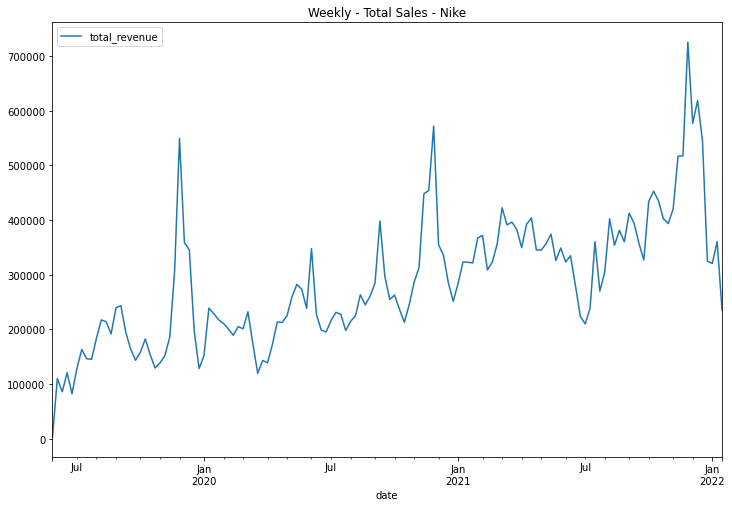

In [10]:
plt.rcParams["figure.figsize"] = (12, 8)
df.plot()
plt.title('Weekly - Total Sales - Nike')
plt.show()

In [11]:
# Check for stationery 

from statsmodels.tsa.stattools import adfuller

X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

    
    


ADF Statistic: -3.799001
p-value: 0.002918
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [35]:
from pmdarima.arima.utils import ndiffs

ndiffs(df, test='adf')

# to select d#

0

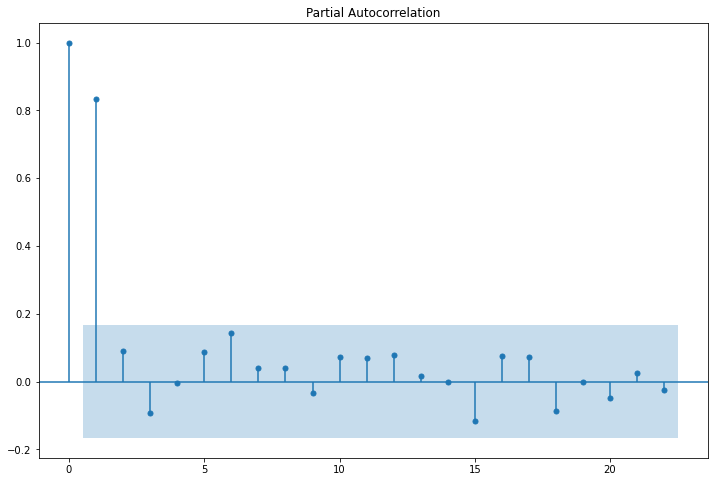

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df);

# to get the p#

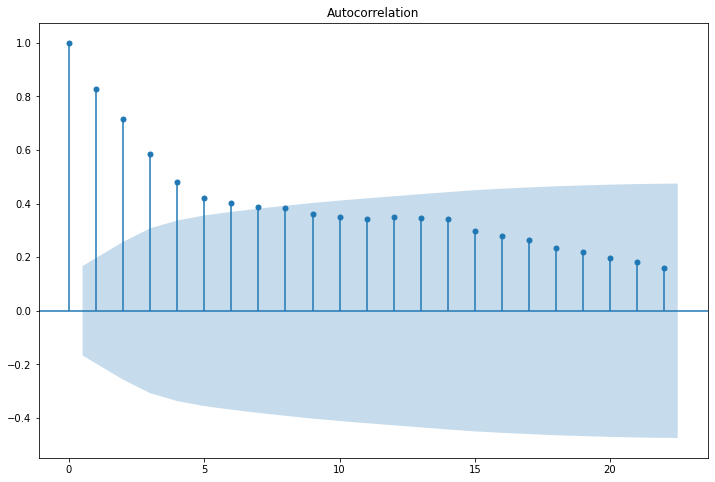

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df);

# to get the q#

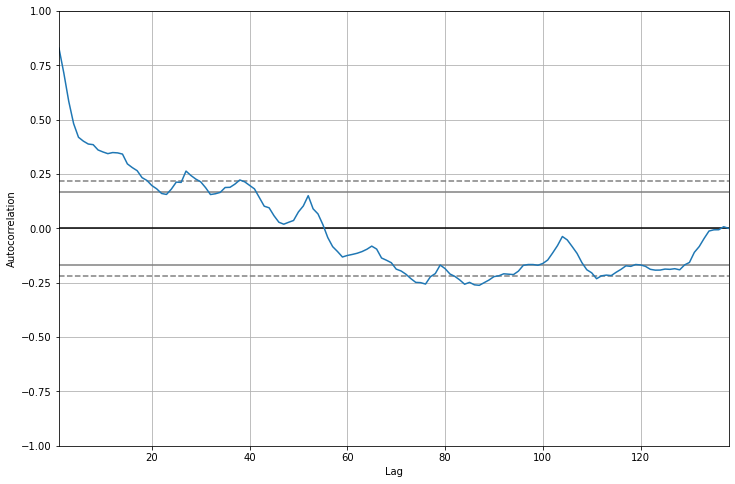

In [37]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(X)
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


model = ARIMA(X, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  138
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1720.516
Date:                Thu, 17 Feb 2022   AIC                           3447.033
Time:                        22:46:07   BIC                           3455.814
Sample:                             0   HQIC                          3450.601
                                - 138                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.862e+05   3.05e+04      9.369      0.000    2.26e+05    3.46e+05
ar.L1          0.8598      0.029     29.810      0.000       0.803       0.916
sigma2      3.773e+09      0.357   1.06e+10      0.0

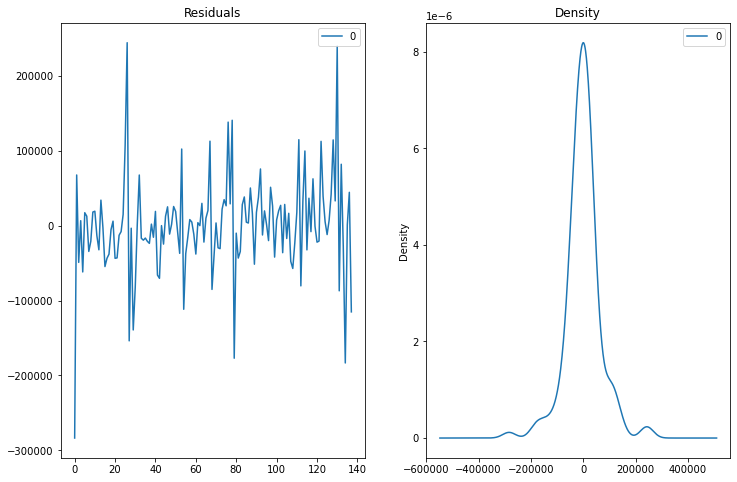

In [13]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [14]:
X = df.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1, 0, 0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)



predicted=358988.294469, expected=349763.499843
predicted=331507.977291, expected=392384.560105
predicted=367968.962041, expected=403879.087256
predicted=378681.624660, expected=345604.137709
predicted=329500.920869, expected=345120.671428
predicted=329418.849674, expected=356906.314767
predicted=339724.463741, expected=374344.498809
predicted=354985.188544, expected=326075.415959
predicted=314247.119792, expected=349065.766245
predicted=333909.348841, expected=323344.244313
predicted=312336.366105, expected=334865.740664
predicted=322262.067162, expected=280466.577444
predicted=276450.367849, expected=224287.290359
predicted=229351.318647, expected=210215.980000
predicted=217482.488608, expected=238973.338379
predicted=241557.943784, expected=360716.161315
predicted=343355.370124, expected=270019.173709
predicted=267574.145524, expected=305197.118142
predicted=296779.029127, expected=402529.503721
predicted=378270.134534, expected=354071.326906
predicted=337759.975326, expected=381450

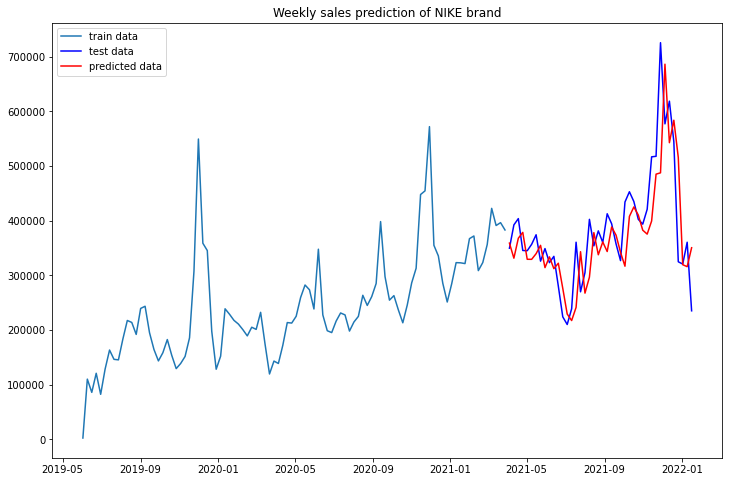

In [18]:
# plot forecasts against actual outcomes


plt.plot(df[:size].index, train, label='train data')
plt.plot(df[size:].index, test, color='blue', label='test data')
plt.plot(df[size:].index, predictions, color='red', label='predicted data')
plt.legend(loc="upper left")
plt.title('Weekly sales prediction of NIKE brand')
plt.show()

In [19]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



mape=mean_absolute_percentage_error(test, predictions)
print('MAPE: ', mape)


### This MAPE metrics to be used in all other ARIMA models. (to compare to fbprophet)

MAPE:  26.850829725095732


In [42]:
forecast = model_fit.forecast(steps=12)


week=1
for yhat in forecast:
    print('week {}: {}'.format(week,yhat))
    week +=  1

week 1: 350626.3037048671
week 2: 341935.0522540462
week 3: 334422.2971464478
week 4: 327928.23934290616
week 5: 322314.7478671776
week 6: 317462.4217097337
week 7: 313268.05012477323
week 8: 309642.41730004334
week 9: 306508.4047039985
week 10: 303799.35074652836
week 11: 301457.6328626417
week 12: 299433.44185950805


In [26]:
# Hypertuning the parameters

import warnings
warnings.filterwarnings("ignore")

In [27]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.7)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
    
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
        
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [28]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    

In [32]:
# evaluate parameters
p_values = [0,1]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=24050045914.121
ARIMA(0, 0, 1) MSE=11554025019.380
ARIMA(0, 1, 0) MSE=5275416809.535
ARIMA(0, 1, 1) MSE=5196228687.702
ARIMA(1, 0, 0) MSE=5163526518.702
ARIMA(1, 0, 1) MSE=5175822270.981
ARIMA(1, 1, 0) MSE=5188105953.946
ARIMA(1, 1, 1) MSE=5747206175.559
Best ARIMA(1, 0, 0) MSE=5163526518.702
